In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math, os, re, sys

In [2]:
# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Possible bin angles.
bin_angles = [4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45]

# List of relevant features and axis names.
wind_features = ['WTP_AW_angle', 'WTP_AW_speed']
boat_speed_feature = 'WTP_SelBoatSpd'
bins_axis_names = ['Wind Angle (˚)', 'Wind Speed (knot)']
boxplot_axis_name = 'Boat Speed (knot)'

In [3]:
def read_csv(fname):
    """Read a CSV file to a Pandas Dataframe"""
    return pd.read_csv(fname, sep=';')

def transform_columns(df, new_cols, regex):
    """Transform the dataset"""
    for col in new_cols:
        filtered = df.filter(regex=(regex.format(col)))
        df[col] = filtered.mean(axis=1)
        df.drop(filtered.columns, axis=1, inplace=True)
    cols = df.columns.values.tolist()
    split = len(cols)-len(new_cols)
    return df[cols[:4] + cols[split:] + cols[4:split]]

def abs_angles(df):
    """Return absolute values of the angle features"""
    for col in df.filter(regex=('.*_angle')).columns:
        df.eval('{0} = abs({0})'.format(col), inplace=True)

def create_bins(df, dx=bin_angles[0], dy=2, min_thresh=100, tries=0):
    """Create bins"""
    bins = {}
    max_x = 0
    while max_x < 180:
        max_y = 0
        while max_y < math.ceil(df.loc[df[wind_features[1]].idxmax()][wind_features[1]]):
            binned_df = df.query('{0} >= {2} and {0} < {2}+{4} & {1} >= {3} & {1} < {3}+{5}'.format(wind_features[0], wind_features[1], max_x, max_y, dx, dy))
            if len(binned_df) >= int(math.ceil(min_thresh * 0.1)):
                if len(binned_df) < min_thresh:
                    return create_bins(df, dx=bin_angles[tries+1], dy=dy+2, min_thresh=min_thresh, tries=tries+1)
                bins['bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)] = binned_df
            max_y+=dy
        max_x+=dx
    return bins, dx, dy, max_x, max_y

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize):
    """Plot wind angle-speed space"""
    plt.xlabel(bins_axis_names[0])
    plt.ylabel(bins_axis_names[1])
    plt.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    plt.xticks(np.arange(x_start, x_finish, dx))
    plt.yticks(np.arange(y_start, y_finish, dy))
    plt.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df):
    """Plot boxplot for boat speed"""
    df.boxplot(column=boat_speed_feature, showfliers=df[boat_speed_feature].median() == df[boat_speed_feature].mode().iloc[0])
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel(boxplot_axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(df):
    """Plot the correlations with boat speed"""
    corrs = {}
    for col in df.drop(['date TU', 'heure TU', 'latitude', 'longitude'], axis=1).columns:
        if col != boat_speed_feature:
            corr = df[boat_speed_feature].corr(df[col])
            if not math.isnan(corr):
                corrs[col] = corr
    sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
    sorted_corrs = sorted(sorted_corrs, key=lambda x: x[1], reverse=True)
    cols = [boat_speed_feature] + [i[0] for i in sorted_corrs]
    corr = df[cols].corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, lw=.75)
    plt.xticks(rotation=30, ha='right', fontsize=5)
    plt.yticks(fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [4]:
# Read from CSV.
df = read_csv('./data/datalog-05102017-Full_1Hz.1s_clean.csv')

# Show examples of the data.
df.head()

,date TU,heure TU,latitude,longitude,Max_1s_FBM_P_lfwd_0_14,Max_1s_FBM_P_lfwd_0_24,Max_1s_FBM_P_lfwd_0_34,Max_1s_FBM_P_lfwd_0_44,Max_1s_FBM_P_uaft_0_12,Max_1s_FBM_P_uaft_0_22,...,WTP_SelHeel,WTP_SelSOG,WTP_SelTrim,WTP_Shroud_Prt_Load,WTP_Shroud_Stb_Load,WTP_TW_angle,WTP_TW_dirn,WTP_TW_speed,WTP_pitch_rate,WTP_yaw_rate
0,2017-10-05,10:51:19,47.7274N,3.3709W,56,65,44,25,48,70,...,1.6,0.10,0.2,0.4,0.0,156,289,11.4,0.0,0.0
1,2017-10-05,10:51:20,47.7274N,3.3709W,10,19,-2,-22,1,23,...,1.6,0.11,0.2,0.4,0.0,156,289,11.4,0.0,0.0
2,2017-10-05,10:51:21,47.7274N,3.3709W,12,21,-1,-23,-2,20,...,1.6,0.10,0.2,0.4,0.0,156,289,11.4,0.0,0.0
3,2017-10-05,10:51:22,47.7274N,3.3709W,11,21,-2,-22,-1,20,...,1.6,0.11,0.2,0.4,0.0,156,289,11.3,0.0,0.0
4,2017-10-05,10:51:23,47.7274N,3.3709W,11,20,-2,-23,-3,19,...,1.6,0.10,0.3,0.4,0.0,155,288,11.1,0.0,0.0


In [5]:
# Transform the dataset to decrease the number of features.
df = transform_columns(df,
                    ['1s_FBM_P_lfwd', '1s_FBM_P_uaft', '1s_FBM_P_ufwd',
                    '1s_FBM_S_laft', '1s_FBM_S_lfwd', '1s_FBM_S_uaft', '1s_FBM_S_ufwd',
                    '1s_HUL_C_lport', '1s_HUL_C_lstbd', '1s_HUL_C_uport', '1s_HUL_C_ustbd',
                    '1s_HUL_P_lport', '1s_HUL_P_lstbd', '1s_HUL_P_uport', '1s_HUL_P_ustbd',
                    '1s_HUL_S_lport', '1s_HUL_S_lstbd', '1s_HUL_S_uport', '1s_HUL_S_ustbd',
                    '1s_Foil_B_P_01_i', '1s_Foil_B_P_01_o',
                    '1s_Foil_B_S_01_i', '1s_Foil_B_S_01_o',
                    '1s_Foil_ELE_C_01_p', '1s_Foil_ELE_C_01_s',
                    '1s_Foil_ELE_LOAD_P', '1s_Foil_ELE_LOAD_S'],
                    '.*{}.*')

# Show examples of the transformed data.
df.head()

,date TU,heure TU,latitude,longitude,1s_FBM_P_lfwd,1s_FBM_P_uaft,1s_FBM_P_ufwd,1s_FBM_S_laft,1s_FBM_S_lfwd,1s_FBM_S_uaft,...,WTP_SelHeel,WTP_SelSOG,WTP_SelTrim,WTP_Shroud_Prt_Load,WTP_Shroud_Stb_Load,WTP_TW_angle,WTP_TW_dirn,WTP_TW_speed,WTP_pitch_rate,WTP_yaw_rate
0,2017-10-05,10:51:19,47.7274N,3.3709W,9.750,31.625,-5.875,0.000,6.000,17.750,...,1.6,0.10,0.2,0.4,0.0,156,289,11.4,0.0,0.0
1,2017-10-05,10:51:20,47.7274N,3.3709W,-1.625,19.875,-17.125,-11.000,-4.750,6.875,...,1.6,0.11,0.2,0.4,0.0,156,289,11.4,0.0,0.0
2,2017-10-05,10:51:21,47.7274N,3.3709W,-0.375,17.875,-19.000,-10.375,-3.750,5.250,...,1.6,0.10,0.2,0.4,0.0,156,289,11.4,0.0,0.0
3,2017-10-05,10:51:22,47.7274N,3.3709W,-0.875,18.625,-18.250,-10.875,-4.500,6.375,...,1.6,0.11,0.2,0.4,0.0,156,289,11.3,0.0,0.0
4,2017-10-05,10:51:23,47.7274N,3.3709W,-0.875,18.000,-18.250,-11.125,-4.125,5.375,...,1.6,0.10,0.3,0.4,0.0,155,288,11.1,0.0,0.0


In [6]:
# Compute absolute values of the angles.
abs_angles(df)

# Show examples of the derived data.
df.head()[wind_features]

,WTP_AW_angle,WTP_AW_speed
0,156,11.3
1,156,11.3
2,156,11.3
3,156,11.2
4,155,11.0


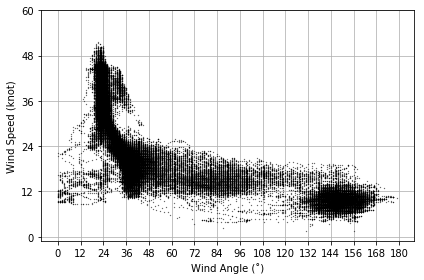

<Figure size 432x288 with 0 Axes>

In [7]:
# Determine the size of the bins using 10 as minimum bin size.
bins, dx, dy, max_x, max_y = create_bins(df, min_thresh=10)

# Plot the resultant bins.
plot_wind_angle_speed(df, 0, 0, max_x+1, max_y+1, dx, dy, 0.25)

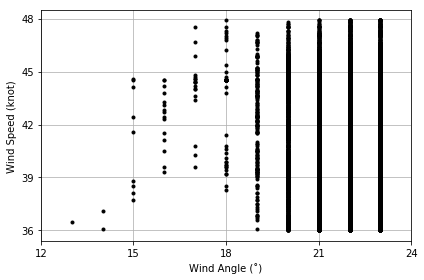

<Figure size 432x288 with 0 Axes>

In [8]:
# Select an example bin (Wind Angle: 12-24˚, Wind Speed: 36-48 Knots).
bin_name = 'bin_x12to24_y36to48'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

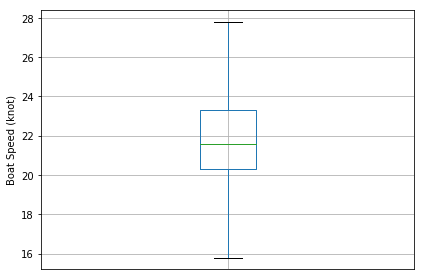

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

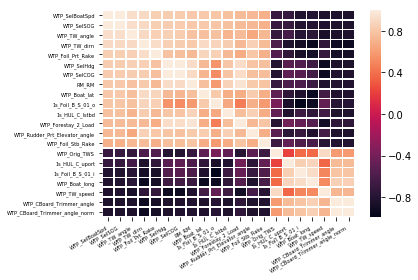

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the correlations with boat speed.
plot_corr(binned_df)

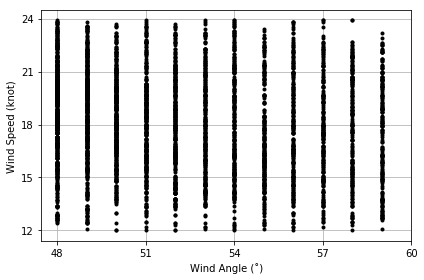

<Figure size 432x288 with 0 Axes>

In [11]:
# Select another example bin (Wind Angle: 48-60˚, Wind Speed: 12-24 Knots).
bin_name = 'bin_x48to60_y12to24'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

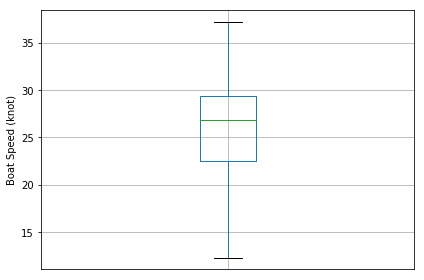

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

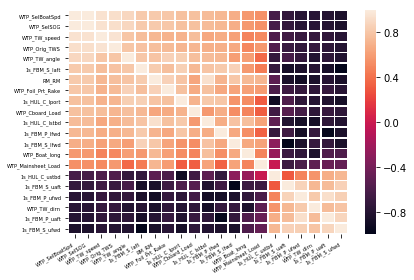

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the correlations with boat speed.
plot_corr(binned_df)

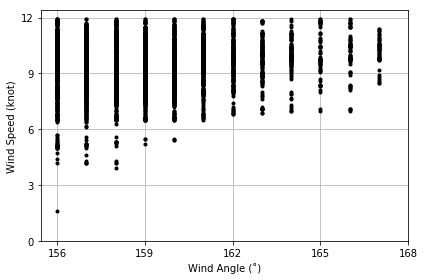

<Figure size 432x288 with 0 Axes>

In [14]:
# Select another example bin (Wind Angle: 156-168˚, Wind Speed: 0-12 Knots).
bin_name = 'bin_x156to168_y0to12'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

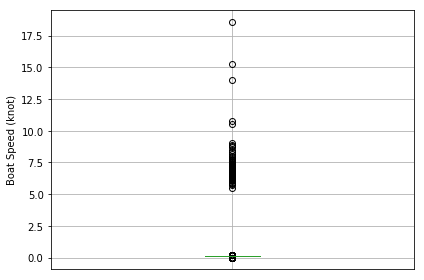

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

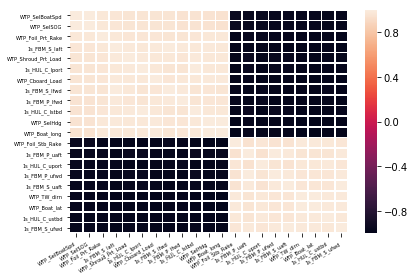

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the correlations with boat speed.
plot_corr(binned_df)

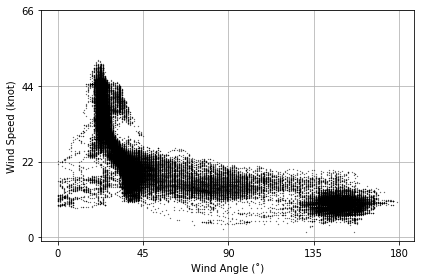

<Figure size 432x288 with 0 Axes>

In [17]:
# Determine another size of the bins using 100 as minimum bin size.
bins, dx, dy, max_x, max_y = create_bins(df, min_thresh=100)

# Plot the resultant bins.
plot_wind_angle_speed(df, 0, 0, max_x+1, max_y+1, dx, dy, 0.25)

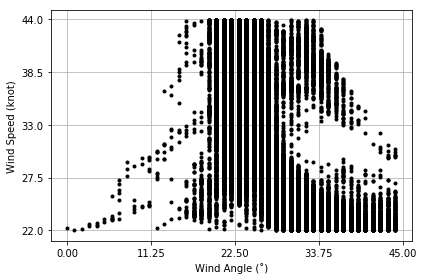

<Figure size 432x288 with 0 Axes>

In [18]:
# Select an example bin (Wind Angle: 0-45˚, Wind Speed: 22-44 Knots).
bin_name = 'bin_x0to45_y22to44'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

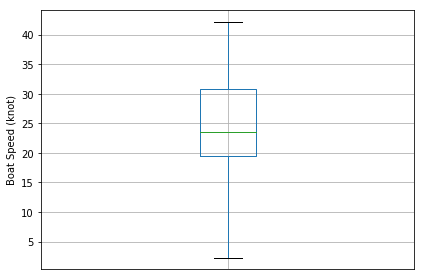

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

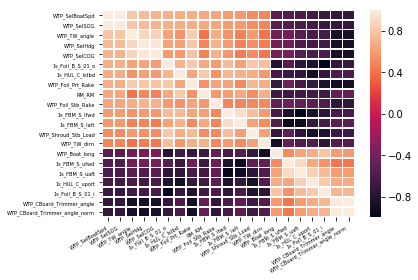

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot the correlations with boat speed.
plot_corr(binned_df)

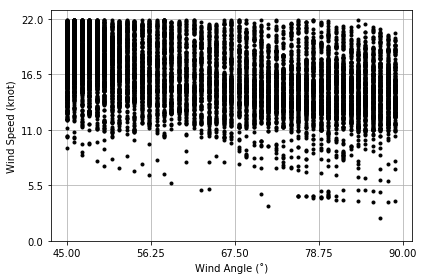

<Figure size 432x288 with 0 Axes>

In [21]:
# Select another example bin (Wind Angle: 45-90˚, Wind Speed: 0-22 Knots).
bin_name = 'bin_x45to90_y0to22'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

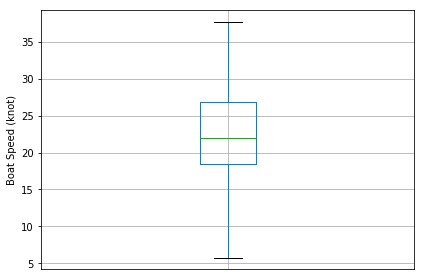

<Figure size 432x288 with 0 Axes>

In [22]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

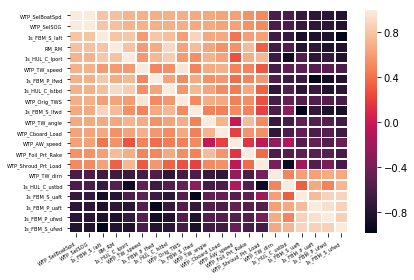

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the correlations with boat speed.
plot_corr(binned_df)

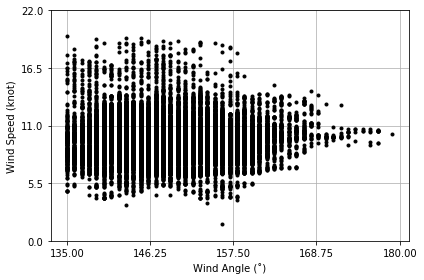

<Figure size 432x288 with 0 Axes>

In [24]:
# Select another example bin (Wind Angle: 135-180˚, Wind Speed: 0-22 Knots).
bin_name = 'bin_x135to180_y0to22'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

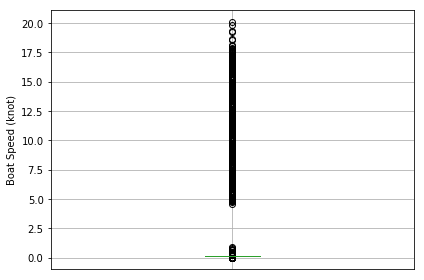

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

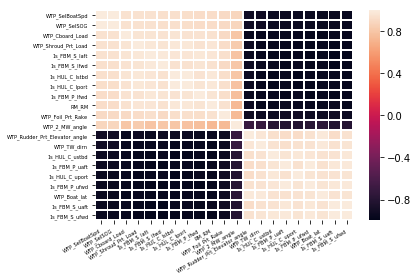

<Figure size 432x288 with 0 Axes>

In [26]:
# Plot the correlations with boat speed.
plot_corr(binned_df)